In [161]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

%matplotlib inline

In [147]:
df = pd.read_csv("zillow_data_2BR.csv")
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,218945.0,...,1147187.0,1146710.0,1147090.0,1147833.0,1148717.0,1148276.0,1152108.0,1160117.0,1164604.0,1164231.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,195076.0,...,405010.0,405461.0,406698.0,408293.0,410351.0,412261.0,414306.0,416267.0,417997.0,419795.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1721974.0,1720842.0,1717028.0,1714060.0,1714273.0,1719429.0,1721641.0,1722443.0,1719270.0,1718401.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,NaN,...,263993.0,264834.0,265177.0,266047.0,267064.0,268704.0,270651.0,273364.0,275817.0,278966.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,210976.0,...,455800.0,455937.0,457165.0,458964.0,461415.0,463713.0,466099.0,468604.0,470797.0,473676.0


----------------------------------------------------------------------

How to melt a dataframe

In [3]:
cheese_list = []

for i in list(df.RegionID):

    one_obsv_df = df.loc[df['RegionID']== i]
    
    cheese = pd.concat([one_obsv_df.RegionID,one_obsv_df.iloc[:,9:]],axis = 1)
    
    cheese = pd.melt(cheese, id_vars =['RegionID'])
    
    cheese_list.append(cheese)
    
cheese_df = pd.concat(cheese_list, axis = 0)

cheese_df.variable = pd.to_datetime(cheese_df.variable)

cheese_df.to_csv('cheese_df.csv',index=False)



--------------------------------------------------------

In [152]:
cheese_df = pd.read_csv('cheese_df.csv')

<AxesSubplot:>

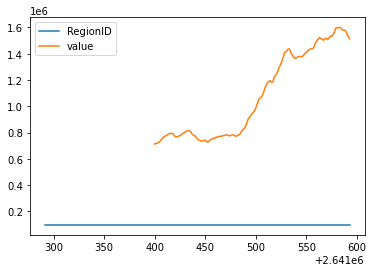

In [154]:
cheese_df[cheese_df.RegionID==97610].plot()

In [5]:
cheese_df.head()

,RegionID,variable,value
0,61639,1996-01-31,218945.0
1,61639,1996-02-29,217413.0
2,61639,1996-03-31,218469.0
3,61639,1996-04-30,220667.0
4,61639,1996-05-31,223952.0


In [6]:
sf_id = list(df[df.CountyName == 'San Francisco County'].RegionID)

sf_cheese_df = pd.concat([cheese_df[cheese_df.RegionID == i] for i in  sf_id], axis = 0)


la_id = list(df[df.CountyName == 'Los Angeles County'].RegionID)

la_cheese_df = pd.concat([cheese_df[cheese_df.RegionID == i] for i in  la_id], axis = 0)

In [7]:
sf_cheese_df.head()

,RegionID,variable,value
3926,97564,1996-01-31,395027.0
3927,97564,1996-02-29,392274.0
3928,97564,1996-03-31,391226.0
3929,97564,1996-04-30,388511.0
3930,97564,1996-05-31,386522.0


<AxesSubplot:>

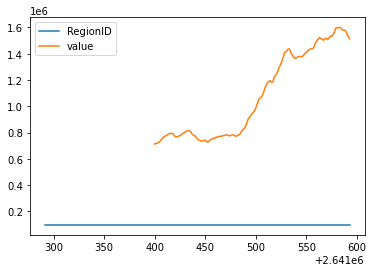

In [156]:
sf_cheese_df[sf_cheese_df.RegionID==97610].plot()

sf_cheese_df_97564 = sf_cheese_df[sf_cheese_df.RegionID == sf_id[0]]

sf_cheese_df_97564.drop('RegionID', inplace = True, axis = 1)

sf_cheese_df_97564.variable = pd.to_datetime(sf_cheese_df_97564.variable)

sf_cheese_df_97564.columns = ['date','value']

sf_cheese_df_97564.set_index('date', inplace = True)

sf_cheese_df_97564.plot() 

-----------------------------------------------------------

<ipython-input-12-0f71746c3f60>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(sf_cheese_df_97564.value, freq=12 )


<Figure size 432x288 with 0 Axes>

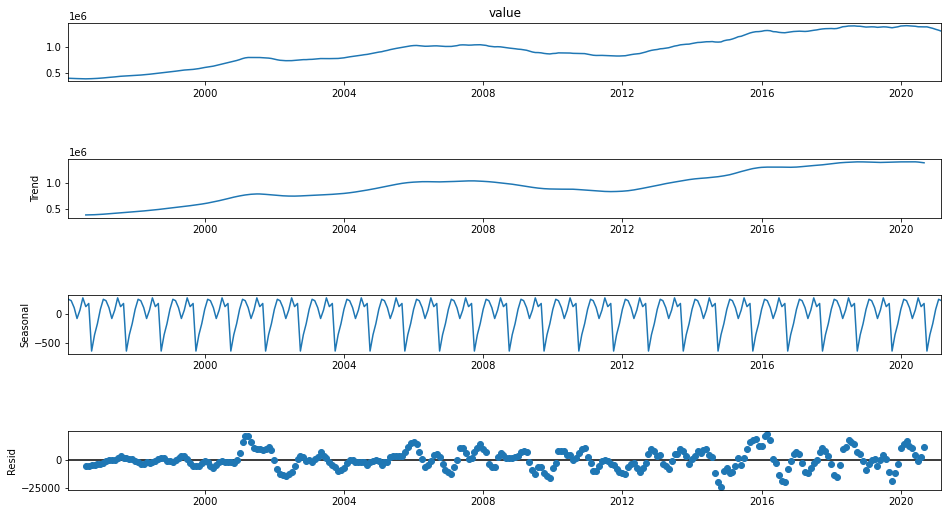

In [12]:

decomposition = seasonal_decompose(sf_cheese_df_97564.value, freq=12 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

sari_mod =SARIMAX(sf_cheese_df_97564,
                  order=(2, 1, 0),
                  seasonal_order=(2, 1, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
forecast = sari_mod.forecast(steps=12)
fig, ax = plt.subplots()
ax.plot(sf_cheese_df_97564.index, sf_cheese_df_97564.value, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title(f'San Fran 97564 Housing Prices 1 year out\n using SARIMAX(2, 1, 0)x(2, 1, 0, 12)')
plt.legend();

------------------------------------------------------

dictionary of dataframes for each zip code

---------------------------------------------------

In [33]:
ids = list(set(sf_cheese_df.RegionID))

keys = ["sf_cheese_df_" + i for i in list(map(str,ids))]

sf_df_list= []

for i in ids:
    
    sf_df_list.append(sf_cheese_df[sf_cheese_df.RegionID == i])
    
    sf_df_list[-1].drop('RegionID', inplace = True, axis = 1)
    
    sf_df_list[-1].columns = ['date', 'value']
    
    sf_df_list[-1].date = pd.to_datetime(sf_df_list[-1].date)
    
    sf_df_list[-1].set_index('date', inplace = True)
    
    sf_df_list[-1] = sf_df_list[-1].asfreq('M')
    
    
    
sf_dict = dict(zip(keys,sf_df_list))



#ids = list(set(la_cheese_df.RegionID))

#keys = ["la_cheese_df_" + i for i in list(map(str,ids))]

#la_df_list= []

#for i in ids:
    
    #la_df_list.append(la_cheese_df[la_cheese_df.RegionID == i])
    
    #la_df_list[-1].drop('RegionID', inplace = True, axis = 1)
    
    #la_df_list[-1].columns = ['date', 'value']
    
    #la_df_list[-1].date = pd.to_datetime(la_df_list[-1].date)
    
    #la_df_list[-1].set_index('date', inplace = True)
    
    #la_df_list[-1] = la_df_list[-1].asfreq('M')
    
    
    
#la_dict = dict(zip(keys,la_df_list))


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

#SF

sf_forecast_dict = {}

for regionid, df  in sf_dict.items():

    sari_mod =SARIMAX(df,
                  order=(2, 1, 0),
                  seasonal_order=(2, 1, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
    forecast = sari_mod.forecast(steps=12)
    sf_forecast_dict[regionid] = forecast
    fig, ax = plt.subplots()
    ax.plot(df.index, df.value, label='Historical')
    ax.plot(forecast, label='Forecast')
    ax.set_title(f'San Francisco {regionid[-5:]} Housing Prices 1 year out\n using SARIMAX(2, 1, 0)x(2, 1, 0, 12)')
    plt.legend();

sf_forecast_dict

#LA

la_forecast_dict = {}

for regionid, df  in la_dict.items():

    sari_mod =SARIMAX(df,
                  order=(2, 1, 0),
                  seasonal_order=(2, 1, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
    forecast = sari_mod.forecast(steps=12)
    sf_forecast_dict[regionid] = forecast
    fig, ax = plt.subplots()
    ax.plot(df.index, df.value, label='Historical')
    ax.plot(forecast, label='Forecast')
    ax.set_title(f'Los Angeles {regionid[-5:]} Housing Prices 1 year out\n using SARIMAX(2, 1, 0)x(2, 1, 0, 12)')
    plt.legend();

<AxesSubplot:xlabel='date'>

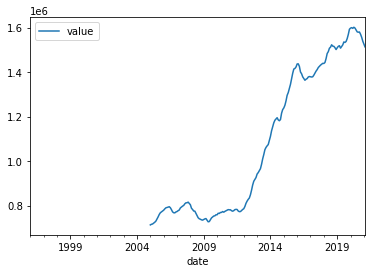

In [159]:
sf_dict['sf_cheese_df_97610'].plot()

----------------------------------------------

Train-test split

-----------------------

In [34]:
cutoff = round(len(sf_dict[list(sf_dict.keys())[0]])*.8)

sf_train_dict_list = [sf_dict[i][:cutoff] for i in list(sf_dict.keys())]

sf_train_dict = dict(zip(list(sf_dict.keys()), sf_train_dict_list))


la_train_dict_list = [la_dict[i][:cutoff] for i in list(la_dict.keys())]

la_train_dict = dict(zip(list(la_dict.keys()), la_train_dict_list))

--------------

parameters for sarimax grid search

-----------

In [35]:
pdq = [(2, 1, 0),(2, 1, 1)]

In [36]:
seasonal_pdq = [(1, 1, 0, 12),(1, 1, 1, 12),(2, 1, 0, 12),(2, 1, 1, 12)]

In [64]:
list(sf_dict.keys())

['sf_cheese_df_97557',
 'sf_cheese_df_97558',
 'sf_cheese_df_97559',
 'sf_cheese_df_97560',
 'sf_cheese_df_97562',
 'sf_cheese_df_97563',
 'sf_cheese_df_97564',
 'sf_cheese_df_97565',
 'sf_cheese_df_97566',
 'sf_cheese_df_97567',
 'sf_cheese_df_97568',
 'sf_cheese_df_97569',
 'sf_cheese_df_97570',
 'sf_cheese_df_97571',
 'sf_cheese_df_97572',
 'sf_cheese_df_97575',
 'sf_cheese_df_97576',
 'sf_cheese_df_97577',
 'sf_cheese_df_97578',
 'sf_cheese_df_97581',
 'sf_cheese_df_97585',
 'sf_cheese_df_97586',
 'sf_cheese_df_97587',
 'sf_cheese_df_97588',
 'sf_cheese_df_97610']

In [87]:
zipcodes = []
param_list = []
param_seasonal_list = []
aic_list = []


#for train in [sf_train_dict[i] for i in list(sf_train_dict.keys())]:

for zipcode, train in sf_train_dict.items():
    
    for param in pdq:
        
        for param_seasonal in seasonal_pdq:
            

                mod=SARIMAX(train,
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                zipcodes.append(zipcode)
                param_list.append(param)
                param_seasonal_list.append(param_seasonal)
                aic_list.append(mod.fit().aic)
                print(aic_list[-1])
           

4309.557298349218
4309.16534191939
3998.7592989433188
4039.5367657050338
4307.268853771408
4306.931212469144
4032.65607775836
4034.012740481002
4236.28459572881
4260.5520720964005
3948.3838937295723
3997.299061882149
4257.261092724057
4257.892678503202
3993.313283482271
3994.617916557194


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


414.67639504346516


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


82.90964840361124
2490.0862705953014


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


77.48270483869798


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


221.52203799127636


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


222.82839264889913


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


223.3223411467987


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


224.6224058266263
4450.742722504852
4451.6876613702425
4181.614919531259
4183.609479077693
4446.396991842852
4447.296609587367
4175.313489618737
4176.0870485070445
4325.877458800607
4326.066854461271
4007.670405046078
4056.8042763694543
4324.170192962542
4324.8738405499025
4053.6507395185795
4057.849592323511
4515.008436164699
4513.670573750414
4241.588702173407
4243.015037717168
4551.4173591489525
4546.959522271581
4239.922610981044
4241.321902785246
4338.522886552168
4339.787575623523
4069.5907653338622
4071.211675960849
4336.443592949679
4337.344111234863
4069.982428313625
4070.561929875593
4313.350983288179
4310.822174312258
3983.729650794909
4033.670009816512
4313.340117747584
4309.650737110969
4032.3040800496137
4033.608398188442
4504.445193327718
4505.47516477703
4187.239302281476
4219.269520482299
4504.688760446214
4537.93130603041
4219.29394341614
4218.459778880711
4185.461985993069
4184.935201664584
3889.507286488811
3925.529754823988
4187.782824757993
4187.836116493054
3922.

/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3944.4946456642037
3982.9466878433805
4364.080793545253
4364.278541030888
4065.2685199088164
4100.5073383743575
4387.686001413811
4363.277281014427
4098.041593866905
4099.368810072599
4144.571779743254
4144.2967689823945
3882.9893853444773
3883.5588603327406
4138.422284424578
4138.13429787524
3875.2561937015407
3875.9038032117096


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


211.96371435534695


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


79.62512162955049


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


169.36970466251358


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


81.68912859907577


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


149.8893517606022


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


151.88955823384265


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


151.88889421699918


/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


153.8888913308987


In [107]:
data = {'zipcodes' : zipcodes,
        'param': param_list,
        'param_seasonal': param_seasonal_list,
        'aic': aic_list}


sf_sarimax_details_df = pd.DataFrame(data)


sf_sarimax_details_df.shape

(200, 4)

In [108]:
sf_sarimax_details_df

,zipcodes,param,param_seasonal,aic
0,sf_cheese_df_97557,"(2, 1, 0)","(1, 1, 0, 12)",4309.557298
1,sf_cheese_df_97557,"(2, 1, 0)","(1, 1, 1, 12)",4309.165342
2,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 0, 12)",3998.759299
3,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 1, 12)",4039.536766
4,sf_cheese_df_97557,"(2, 1, 1)","(1, 1, 0, 12)",4307.268854
...,...,...,...,...
195,sf_cheese_df_97610,"(2, 1, 0)","(2, 1, 1, 12)",81.689129
196,sf_cheese_df_97610,"(2, 1, 1)","(1, 1, 0, 12)",149.889352
197,sf_cheese_df_97610,"(2, 1, 1)","(1, 1, 1, 12)",151.889558
198,sf_cheese_df_97610,"(2, 1, 1)","(2, 1, 0, 12)",151.888894


In [112]:
sf_sarimax_details_df.loc[sf_sarimax_details_df.groupby("zipcodes")["aic"].idxmin()]

,zipcodes,param,param_seasonal,aic
2,sf_cheese_df_97557,"(2, 1, 0)","(2, 1, 0, 12)",3998.759299
10,sf_cheese_df_97558,"(2, 1, 0)","(2, 1, 0, 12)",3948.383894
19,sf_cheese_df_97559,"(2, 1, 0)","(2, 1, 1, 12)",77.482705
30,sf_cheese_df_97560,"(2, 1, 1)","(2, 1, 0, 12)",4175.313490
34,sf_cheese_df_97562,"(2, 1, 0)","(2, 1, 0, 12)",4007.670405
46,sf_cheese_df_97563,"(2, 1, 1)","(2, 1, 0, 12)",4239.922611
50,sf_cheese_df_97564,"(2, 1, 0)","(2, 1, 0, 12)",4069.590765
58,sf_cheese_df_97565,"(2, 1, 0)","(2, 1, 0, 12)",3983.729651
66,sf_cheese_df_97566,"(2, 1, 0)","(2, 1, 0, 12)",4187.239302
74,sf_cheese_df_97567,"(2, 1, 0)","(2, 1, 0, 12)",3889.507286


In [118]:
sf_sarimax_details_df['zipcodes']= [i[-5:] for i in sf_sarimax_details_df.zipcodes]

In [127]:
sf_best_df = sf_best_df.loc[sf_sarimax_details_df.groupby("zipcodes")["aic"].idxmin()]
sf_best_df.set_index('zipcodes', inplace = True)

In [133]:
sf_best_df.loc['97610'].param

(2, 1, 0)

In [140]:
sf_best_df.loc[regionid]

param                 (2, 1, 0)
param_seasonal    (1, 1, 1, 12)
aic                     79.6251
Name: 97610, dtype: object

<ipython-input-164-03d8bd9ddc39>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/Users/jonathansilverman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


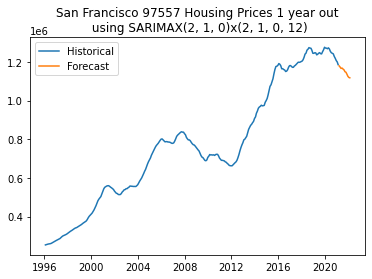

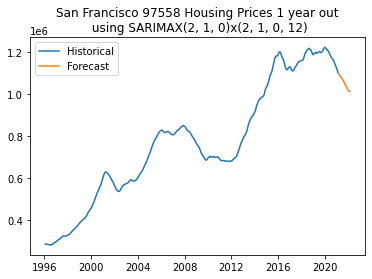

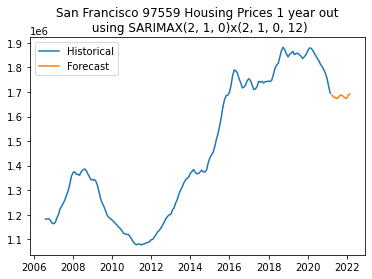

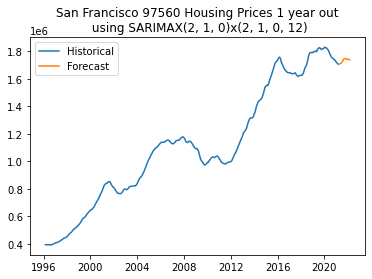

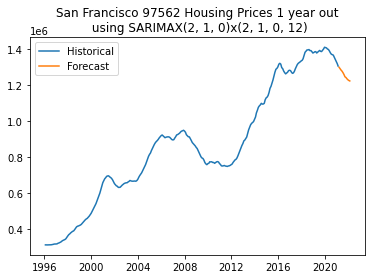

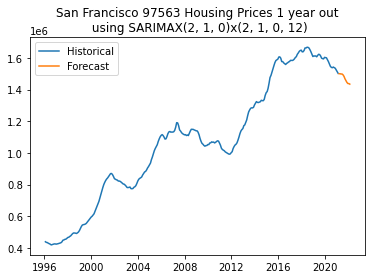

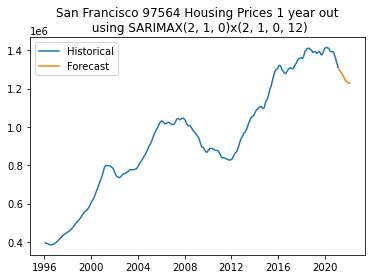

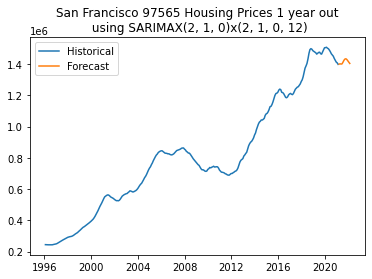

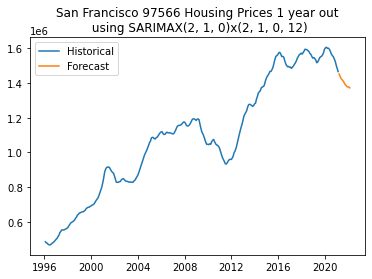

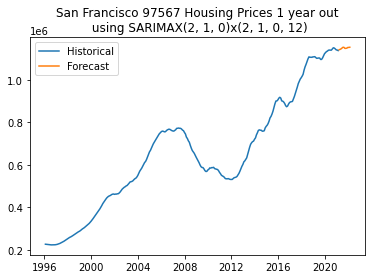

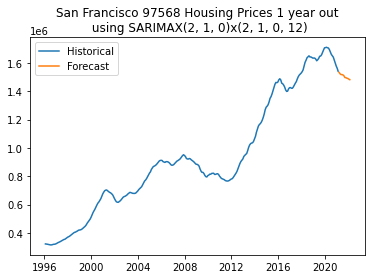

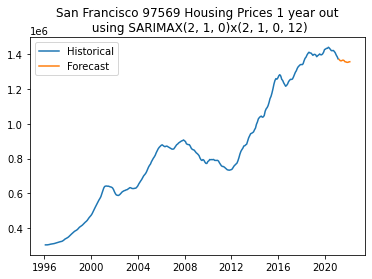

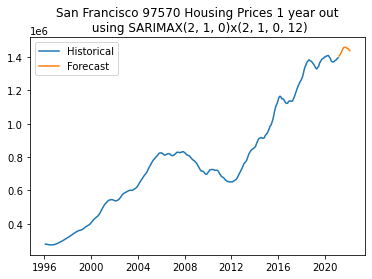

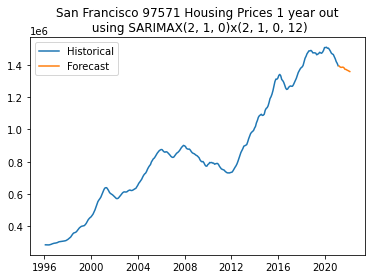

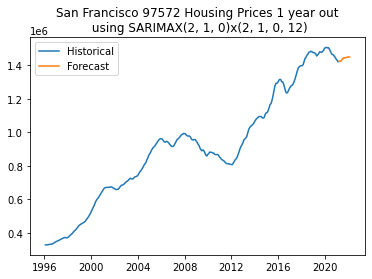

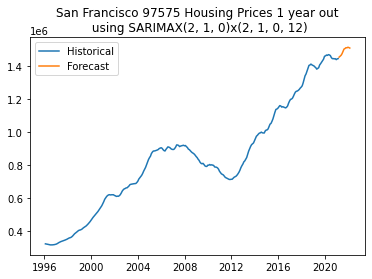

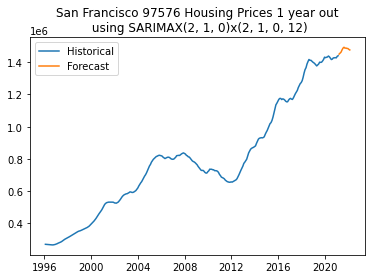

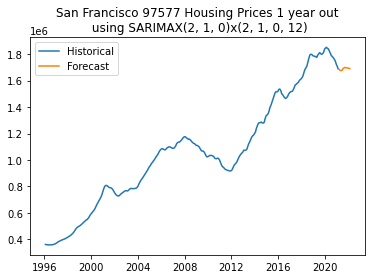

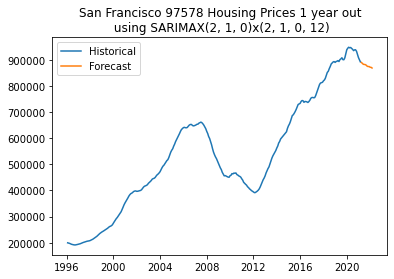

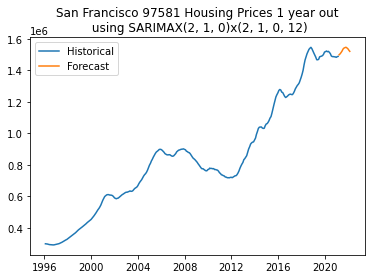

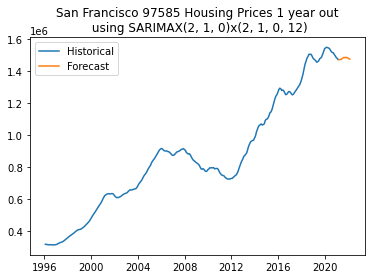

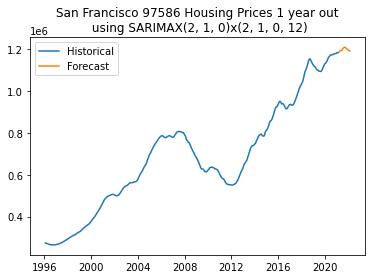

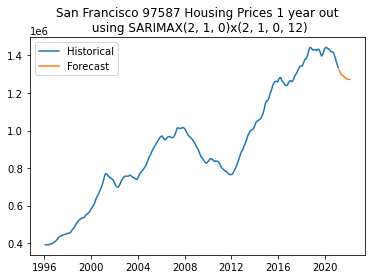

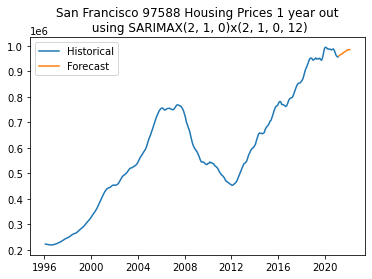

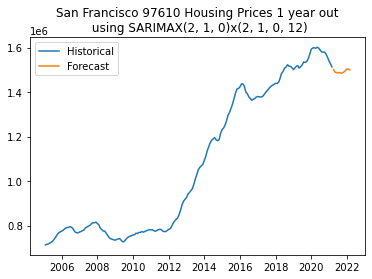

In [164]:
sf_forecast_dict = {}

for regionid, df in sf_dict.items():

    regionid = regionid[-5:]
    #df.plot()
    #plt.show()
    sari_mod = SARIMAX(df.dropna(),
                       
                       order=sf_best_df.loc[regionid].param,
                       
                       seasonal_order=sf_best_df.loc[regionid].param_seasonal,
                       
                       enforce_stationarity=False,
                       
                       enforce_invertibility=False).fit()
    
    forecast = sari_mod.forecast(steps=12)
    sf_forecast_dict[regionid] = forecast
    fig, ax = plt.subplots()
    ax.plot(df.index, df.value, label='Historical')
    ax.plot(forecast, label='Forecast')
    ax.set_title(
        f'San Francisco {regionid} Housing Prices 1 year out\n using SARIMAX(2, 1, 0)x(2, 1, 0, 12)')
    plt.legend()

In [170]:
sf_forecast_dict

{'97557': 2021-03-31    1.178978e+06
 2021-04-30    1.173008e+06
 2021-05-31    1.165721e+06
 2021-06-30    1.167593e+06
 2021-07-31    1.162613e+06
 2021-08-31    1.158323e+06
 2021-09-30    1.148807e+06
 2021-10-31    1.146076e+06
 2021-11-30    1.136113e+06
 2021-12-31    1.124874e+06
 2022-01-31    1.118999e+06
 2022-02-28    1.117291e+06
 Freq: M, Name: predicted_mean, dtype: float64,
 '97558': 2021-03-31    1.094153e+06
 2021-04-30    1.087257e+06
 2021-05-31    1.079236e+06
 2021-06-30    1.074314e+06
 2021-07-31    1.066560e+06
 2021-08-31    1.058359e+06
 2021-09-30    1.046562e+06
 2021-10-31    1.039767e+06
 2021-11-30    1.029471e+06
 2021-12-31    1.019844e+06
 2022-01-31    1.014639e+06
 2022-02-28    1.012911e+06
 Freq: M, Name: predicted_mean, dtype: float64,
 '97559': 2021-03-31    1.687642e+06
 2021-04-30    1.680127e+06
 2021-05-31    1.677121e+06
 2021-06-30    1.673006e+06
 2021-07-31    1.678266e+06
 2021-08-31    1.686999e+06
 2021-09-30    1.686869e+06
 2021-10-

In [193]:
table_dict = {'zipcode': list(sf_forecast_dict.keys()) ,
              'current_value': [df.iloc[-1].values[0] for df in list(sf_dict.values())] ,
              'forecasted_value': [df.iloc[-1] for df in list(sf_forecast_dict.values())]
             }

final_df = pd.DataFrame(table_dict)

In [196]:
final_df['percent_change'] = round(100*(final_df.forecasted_value - final_df.current_value )/final_df.current_value,2)

In [200]:
final_df.sort_values('percent_change', axis = 0, ascending=False)

,zipcode,current_value,forecasted_value,percent_change
15,97575,1443658.0,1.507369e+06,4.41
12,97570,1395930.0,1.438780e+06,3.07
23,97588,956182.0,9.848421e+05,3.00
16,97576,1439525.0,1.475448e+06,2.50
19,97581,1488832.0,1.520768e+06,2.15
14,97572,1421186.0,1.449162e+06,1.97
3,97560,1706714.0,1.738443e+06,1.86
9,97567,1137737.0,1.153425e+06,1.38
21,97586,1182842.0,1.191954e+06,0.77
7,97565,1398923.0,1.404549e+06,0.40
